In [35]:
#Simon du Toit 22580530
#Movie recommender system based on matrix factorization and alternating least squares

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import time
import multiprocessing
from numba import jit, prange, bool_
import random

In [99]:
#load CSV
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

#remap IDs
u_i = ratings['userId'].unique()
m_i = ratings['movieId'].unique()

uN = u_i.size
mN = m_i.size

u_map = {}
for i, u in enumerate(u_i):
    u_map[u] = i
    
m_map = {}
for i, m in enumerate(m_i):
    m_map[m] = i
    
ratings['userId'] = ratings['userId'].map(u_map)
ratings['movieId'] = ratings['movieId'].map(m_map)
movies['movieId'] = movies['movieId'].map(m_map)

#create one-hot encodings for genres
def get_genres(s):
    return s.split('|')

movies['genres'] = movies['genres'].map(get_genres)

genres = set(())
for m in movies.values:
    for g in m[2]:
        genres.add(g)
genres.remove('(no genres listed)')

def gbits(g):
    bits = np.zeros(19)
    for i, genre in enumerate(genres):
        if genre in g:
            bits[i] = 1
    return bits

movies['gbits'] = movies['genres'].map(gbits)

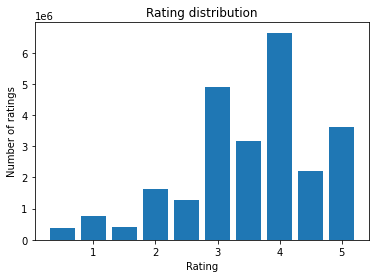

mean rating = 3.533854451353085
median rating = 3.5


In [395]:
rating_values = np.asarray(ratings.rating)
rating_dist = np.unique(rating_values, return_counts = True)
plt.bar(rating_dist[0], rating_dist[1], width = 0.4)
plt.title('Rating distribution')
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.show()
print('mean rating =', rating_values.mean())
print('median rating =', np.median(rating_values))

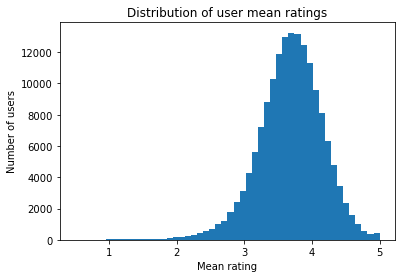

mean user mean rating = 3.6792050363089


In [396]:
user_biases = np.asarray(ratings.groupby('userId').mean().rating)
plt.hist(user_biases, bins=50)
plt.title('Distribution of user mean ratings')
plt.xlabel('Mean rating')
plt.ylabel('Number of users')
plt.show()
print('mean user mean rating =', user_biases.mean())

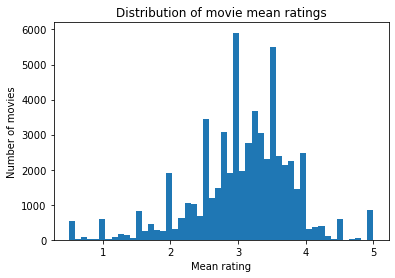

mean item mean rating = 3.07137392095113


In [397]:
movie_biases = np.asarray(ratings.groupby('movieId').mean().rating)
plt.hist(movie_biases, bins=50)
plt.title('Distribution of movie mean ratings')
plt.xlabel('Mean rating')
plt.ylabel('Number of movies')
plt.show()
print('mean item mean rating =', movie_biases.mean())

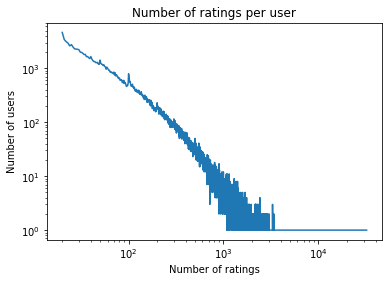

In [398]:
user_counts = np.sort(np.asarray(ratings.groupby('userId').count().rating))
user_dist = np.unique(user_counts, return_counts = True)
plt.loglog(user_dist[0], user_dist[1])
plt.title('Number of ratings per user')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

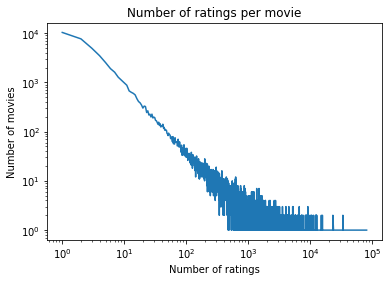

In [399]:
movie_counts = np.sort(np.asarray(ratings.groupby('movieId').count().rating))
movie_dist = np.unique(movie_counts, return_counts = True)
plt.loglog(movie_dist[0], movie_dist[1])
plt.title('Number of ratings per movie')
plt.xlabel('Number of ratings')
plt.ylabel('Number of movies')
plt.show()

In [148]:
#randomly select a portion of the ratings from each user
@jit(nopython=True, parallel=True)
def train_test_split(user_indices, train_ratio):
    N = user_indices[-1]
    train = np.zeros(N, dtype=bool_)
        
    indices = np.arange(user_indices[0])
    mask = np.random.choice(indices.size, int(indices.size*train_ratio),replace=False)
    train[indices[mask]] = True
    
    for i in prange(user_indices.size-1):    
        indices = np.arange(user_indices[i], user_indices[i+1])
        mask = np.random.choice(indices.size, int(indices.size*train_ratio),replace=False)
        train[indices[mask]] = True

    return train

In [149]:
#split into train, validation and test sets
user_indices = np.asarray(ratings.groupby('userId').count().cumsum().rating)
train = train_test_split(user_indices, train_ratio=0.8)
ratings_normalized = ratings.copy()
ratings_normalized.rating = ratings_normalized.rating - ratings_normalized.rating.mean()
ratings_train = ratings_normalized[train]
ratings_not_train = ratings_normalized[np.invert(train)]
not_train_user_indices = np.asarray(ratings_not_train.groupby('userId').count().cumsum().rating)
validation = train_test_split(not_train_user_indices, train_ratio=0.5)
ratings_valid = ratings_not_train[validation]
ratings_test = ratings_not_train[np.invert(validation)]

In [150]:
#create user indices
ordered_by_user = ratings_train.sort_values('userId')
movies_per_user = np.asarray(ordered_by_user.movieId)
ratings_per_user = np.asarray(ordered_by_user.rating)
user_indices = np.concatenate(([0], np.asarray(ordered_by_user.groupby('userId').count().cumsum().rating)))

#create movie indices
ordered_by_movie = ratings_train.sort_values('movieId')
users_per_movie = np.asarray(ordered_by_movie.userId)
ratings_per_movie = np.asarray(ordered_by_movie.rating)
movie_indices = np.concatenate(([0], np.asarray(ordered_by_movie.groupby('movieId').count().cumsum().rating)))
movies_in_train_set = np.unique(np.asarray(ordered_by_movie.movieId))

#create user indices for validation and testing
ordered_by_user_valid = ratings_valid.sort_values('userId')
movies_per_user_valid = np.asarray(ordered_by_user_valid.movieId)
ratings_per_user_valid = np.asarray(ordered_by_user_valid.rating)
user_indices_valid = np.concatenate(([0], np.asarray(ordered_by_user_valid.groupby('userId').count().cumsum().rating)))

ordered_by_user_test = ratings_test.sort_values('userId')
movies_per_user_test = np.asarray(ordered_by_user_test.movieId)
ratings_per_user_test = np.asarray(ordered_by_user_test.rating)
user_indices_test = np.concatenate(([0], np.asarray(ordered_by_user_test.groupby('userId').count().cumsum().rating)))

In [261]:
#Alternating Least Squares (biases only)
@jit(nopython=True, parallel=True, boundscheck=True)
def alternating_least_squares_bias(bu, bm, params, verbose): 
    
    T, l, t, a, k = params
    T = int(T)
    k = int(k)
    
    if (verbose):
        print('training error and loss:')
        
    N = train.sum()
    mN_train = movies_in_train_set.size
    
    rmses = np.empty(T)
    losses = np.empty(T)
    
    for i in np.arange(T):
            
        #Update user vectors
        for userId in prange(uN):         
                
            start = user_indices[userId]
            end = user_indices[userId+1]           
            domain = movies_per_user[start:end]           
            r = ratings_per_user[start:end]
            
            #update bias
            bu[userId] = l*np.sum(r - bm[domain])/(a + l*domain.size)

        #Update movie vectors
        for movieIndex in prange(mN_train):
            
            movieId = movies_in_train_set[movieIndex]
            start = movie_indices[movieIndex]
            end = movie_indices[movieIndex+1]         
            domain = users_per_movie[start:end]           
            r = ratings_per_movie[start:end]
            
            #update bias
            bm[movieId] = l*np.sum(r - bu[domain])/(a + l*domain.size)

        #Compute loss and error
        squared_error = 0
        for userId in prange(uN):
                            
            start = user_indices[userId]
            end = user_indices[userId+1]               
            domain = movies_per_user[start:end]
            r = ratings_per_user[start:end]
            
            squared_error += np.sum((r - (bu[userId] + bm[domain]))**2)
        rmse = np.sqrt(squared_error/N)
        loss = (-l/2) * squared_error - (a/2) * ((bu * bu).sum() + (bm * bm).sum())
        rmses[i] = rmse
        losses[i] = loss        
        
        if (verbose):
            print(rmse, loss)
    return rmses, losses

In [132]:
#Compute validation error (biases only)
@jit(nopython=True, parallel=True, boundscheck=False)
def comp_valid_error_bias(bu, bm):
    N = validation.sum()
    rse = 0
    squared_error = 0
    error = 0
    for userId in prange(uN):

        start = user_indices_valid[userId]
        end = user_indices_valid[userId+1]

        domain = movies_per_user_valid[start:end]
        r = ratings_per_user_valid[start:end]

        squared_error += np.sum((r - bu[userId] + bm[domain])**2)
    rmse = np.sqrt(squared_error/N)
    loss = (-l/2) * squared_error-(a/2)*((bu*bu).sum()+(bm*bm).sum())
    return rmse, loss

In [386]:
T = 20
l = 0.01
t = 0.1
a = 1.0
k = 20

params = np.asarray([T, l, t, a, k])

bu = np.zeros(uN)
bm = np.zeros(mN)

start = time.time()
rmses, losses = alternating_least_squares_bias(bu, bm, params, True)
end = time.time()
print('validation error and loss:')
print(comp_valid_error_bias(bu, bm))
print('execution time:', end - start)

training error and loss:
0.8783981119821812 -81473.0351692469
0.8720391376540064 -79946.03903144259
0.8716368896601874 -79894.94104302594
0.8715203000100825 -79882.45437002374
0.8714627464680393 -79877.6675493583
0.8714294678914801 -79875.78292322185
0.871409296447473 -79875.03947930876
0.8713968661895328 -79874.74613686535
0.8713891475832406 -79874.63038762333
0.87138433395955 -79874.58471412698
0.871381324006225 -79874.56669179993
0.8713794387231177 -79874.55958035987
0.8713782566181787 -79874.55677425273
0.8713775149175904 -79874.55566698922
0.8713770493459402 -79874.55523007335
0.8713767570240418 -79874.55505767059
0.8713765734506054 -79874.55498964217
0.8713764581571397 -79874.55496279872
0.8713763857421107 -79874.55495220656
0.8713763402568112 -79874.55494802701
validation error and loss:
(1.233733962114775, -23141.489229514584)
execution time: 8.370999813079834


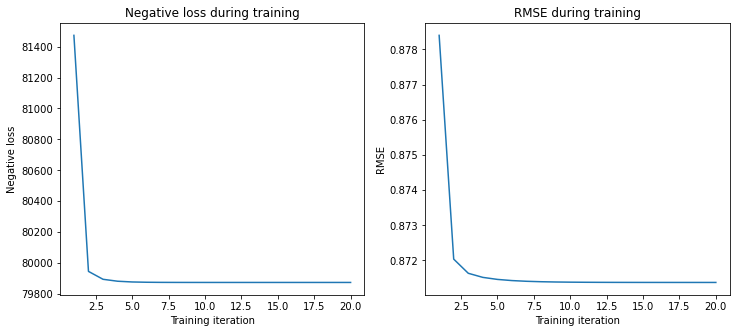

In [387]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.arange(T)+1, -losses)
plt.title('Negative loss during training')
plt.xlabel('Training iteration')
plt.ylabel('Negative loss')

plt.subplot(1,2,2)
plt.plot(np.arange(T)+1,rmses)
plt.title('RMSE during training')
plt.xlabel('Training iteration')
plt.ylabel('RMSE')
plt.show()

In [259]:
#Alternating Least Squares
@jit(nopython=True, parallel=True, boundscheck=False)
def alternating_least_squares(U, V, bu, bm, params, verbose): 
    
    T, l, t, a, k = params
    T = int(T)
    k = int(k)
    
    if (verbose):
        print('training error and loss:')
    
    N = train.sum()
    mN_train = movies_in_train_set.size
    rmses = np.empty(T)
    losses = np.empty(T)
    
    for i in np.arange(T):

        #Update user vectors
        for userId in prange(uN):         
                
            start = user_indices[userId]
            end = user_indices[userId+1]
            domain = movies_per_user[start:end]           
            r = ratings_per_user[start:end]
            
            #update bias
            bu[userId] = l*np.sum(r - (U[userId] @ V[domain].T + bm[domain]))/(a + l*domain.size)
            
            #update trait vector
            lhs = np.linalg.inv(l*(V[domain].T @ V[domain]) + t*np.eye(k))
            rhs = l*((r-bu[userId]-bm[domain]) @ V[domain])
            U[userId] = lhs @ rhs

        #Update movie vectors
        for movieIndex in prange(mN_train):
            
            movieId = movies_in_train_set[movieIndex]
            start = movie_indices[movieIndex]
            end = movie_indices[movieIndex+1]         
            domain = users_per_movie[start:end]           
            r = ratings_per_movie[start:end]
            
            #update bias
            bm[movieId] = l*np.sum(r - (V[movieId] @ U[domain].T + bu[domain]))/(a + l*domain.size)

            #update trait vector
            lhs = np.linalg.inv(l*(U[domain].T @ U[domain]) + t*np.eye(k))
            rhs = l*((r-bu[domain]-bm[movieId]) @ U[domain])
            V[movieId] = lhs @ rhs

        #Compute loss and error
        squared_error = 0
        for userId in prange(uN):
                            
            start = user_indices[userId]
            end = user_indices[userId+1]
                
            domain = movies_per_user[start:end]
            r = ratings_per_user[start:end]
            
            squared_error += np.sum((r - (U[userId] @ V[domain].T + bu[userId] + bm[domain]))**2)
        rmse = np.sqrt(squared_error/N)
        loss = (-l/2) * squared_error-(t/2)*((U*U).sum()+(V*V).sum())-(a/2)*((bu*bu).sum()+(bm*bm).sum())
        rmses[i] = rmse
        losses[i] = loss
        
        if (verbose):
            print(rmse, loss)
    return rmses, losses

In [152]:
#Compute validation error
@jit(nopython=True, parallel=True, boundscheck=False)
def comp_valid_error(U, V, bu, bm):
    N = validation.sum()
    rse = 0
    squared_error = 0
    error = 0
    for userId in prange(uN):

        start = user_indices_valid[userId]
        end = user_indices_valid[userId+1]

        domain = movies_per_user_valid[start:end]
        r = ratings_per_user_valid[start:end]

        squared_error += np.sum((r - (U[userId] @ V[domain].T + bu[userId] + bm[domain]))**2)
    rmse = np.sqrt(squared_error/N)
    loss = (-l/2) * squared_error-(t/2)*((U*U).sum()+(V*V).sum())-(a/2)*((bu*bu).sum()+(bm*bm).sum())
    return rmse, loss

In [384]:
T = 20
l = 0.01
t = 0.1
a = 1.0
k = 20

params = np.asarray([T, l, t, a, k])

U = np.random.normal(0, np.sqrt(2.5)/k,((uN, k)))
V = np.random.normal(0, np.sqrt(2.5)/k,((mN, k)))
bu = np.zeros(uN)
bm = np.zeros(mN)

start = time.time()
rmses, losses = alternating_least_squares(U, V, bu, bm, params, True)
end = time.time()
print('validation error and loss:')
print(comp_valid_error(U, V, bu, bm))
print('execution time:', end - start)

training error and loss:
0.8375822519259781 -76205.93288659462
0.7327340126651892 -62039.48606231697
0.705112283645461 -57487.53171851222
0.6927510501231613 -55443.52526495948
0.6861502881011242 -54342.81825677434
0.6822591961984305 -53687.449953776464
0.6797897538299105 -53265.89065781217
0.6781450276940695 -52980.574097401186
0.6770108231235878 -52780.40182104875
0.6762055506752709 -52635.839929122776
0.6756186160147645 -52528.75151662236
0.6751802411413922 -52447.545885319436
0.6748452095034809 -52384.610850831596
0.6745836046075714 -52334.845543667725
0.6743752708899713 -52294.770892827226
0.6742063887681894 -52261.971432012535
0.674067319942828 -52234.73938815949
0.6739512293543178 -52211.845076434736
0.6738531819853011 -52192.38658563721
0.673769540587888 -52175.69001709576
validation error and loss:
(0.7858657413357377, -14614.761002228719)
execution time: 201.1330316066742


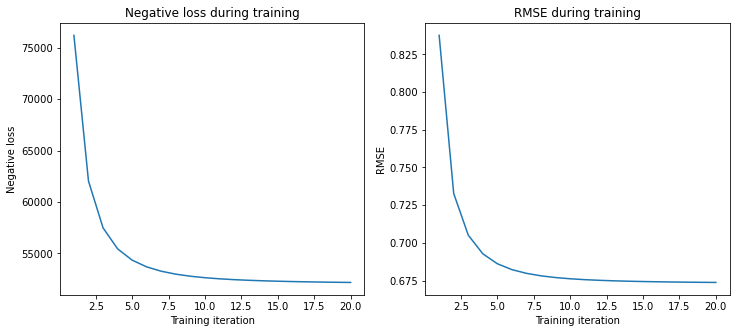

In [385]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.arange(T)+1, -losses)
plt.title('Negative loss during training')
plt.xlabel('Training iteration')
plt.ylabel('Negative loss')

plt.subplot(1,2,2)
plt.plot(np.arange(T)+1,rmses)
plt.title('RMSE during training')
plt.xlabel('Training iteration')
plt.ylabel('RMSE')
plt.show()

In [388]:
#Random search over hyperparamter grid
min_valid_rmse = 1.0
min_params = np.zeros(5)
for i in range(20):
    T = 20
    l = np.random.choice([0.001, 0.01, 0.1, 1.0])
    t = np.random.choice([0.001, 0.01, 0.1, 1.0])
    a = np.random.choice([0.001, 0.01, 0.1, 1.0])
    k = np.random.choice(29) + 2

    params = np.asarray([T, l, t, a, k])

    U = np.random.normal(0, np.sqrt(2.5)/k,((uN, k)))
    V = np.random.normal(0, np.sqrt(2.5)/k,((mN, k)))
    bu = np.zeros(uN)
    bm = np.zeros(mN)

    rmses, losses = alternating_least_squares(U, V, bu, bm, params, False)
    new_valid_rmse = comp_valid_error(U, V, bu, bm)[0]
    if new_valid_rmse < min_valid_rmse:
        min_valid_rmse = new_valid_rmse
        min_params = params.copy()
        print('new min rmse:', min_valid_rmse)
        print('new min params:', min_params)
    print('iteration', i, 'done')

new min rmse: 0.8238770317715142
new min params: [2.0e+01 1.0e-02 1.0e-02 1.0e+00 2.4e+01]
iteration 0 done
iteration 1 done
new min rmse: 0.8125527724621417
new min params: [2.e+01 1.e-02 1.e-02 1.e-02 2.e+01]
iteration 2 done
iteration 3 done
iteration 4 done
iteration 5 done
iteration 6 done
new min rmse: 0.8112897001805981
new min params: [2.e+01 1.e-02 1.e-01 1.e-01 3.e+00]
iteration 7 done
iteration 8 done
new min rmse: 0.8102643120898045
new min params: [20.   0.1  1.   0.1  3. ]
iteration 9 done
new min rmse: 0.8027772386271448
new min params: [2.e+01 1.e+00 1.e+00 1.e-02 4.e+00]
iteration 10 done
new min rmse: 0.7859376443122786
new min params: [20.   0.1  1.   1.   8. ]
iteration 11 done
iteration 12 done
iteration 13 done
iteration 14 done
iteration 15 done
iteration 16 done
iteration 17 done
iteration 18 done
iteration 19 done


In [393]:
#Compute test error
@jit(nopython=True, parallel=True, boundscheck=False)
def comp_test_error(U, V, bu, bm):
    N = np.invert(validation).sum()
    rse = 0
    squared_error = 0
    error = 0
    for userId in prange(uN):

        start = user_indices_test[userId]
        end = user_indices_test[userId+1]

        domain = movies_per_user_test[start:end]
        r = ratings_per_user_test[start:end]

        squared_error += np.sum((r - (U[userId] @ V[domain].T + bu[userId] + bm[domain]))**2)
    rmse = np.sqrt(squared_error/N)
    loss = (-l/2) * squared_error-(t/2)*((U*U).sum()+(V*V).sum())-(a/2)*((bu*bu).sum()+(bm*bm).sum())
    return rmse, loss

In [394]:
#Use best parameters
T = 20
l = 0.1
t = 1.0
a = 1.0
k = 20

params = np.asarray([T, l, t, a, k])

U = np.random.normal(0, np.sqrt(2.5)/k,((uN, k)))
V = np.random.normal(0, np.sqrt(2.5)/k,((mN, k)))
bu = np.zeros(uN)
bm = np.zeros(mN)

start = time.time()
rmses, losses = alternating_least_squares(U, V, bu, bm, params, True)
end = time.time()
print('validation error and loss:')
print(comp_test_error(U, V, bu, bm))
print('execution time:', end - start)

training error and loss:
0.8266130722823922 -712823.1568358636
0.7251199253507253 -580895.8961162012
0.6968868875009852 -543725.4624220257
0.6854299248646425 -528758.4425778631
0.679624283361761 -521076.4165627233
0.6762358243275226 -516520.15921970585
0.67406128572059 -513559.71612262796
0.6725774834813201 -511522.66964240524
0.6715204793732605 -510062.56483907514
0.6707411726572632 -508980.60562275525
0.6701494701345906 -508155.7283354159
0.6696886145029672 -507511.366762727
0.6693217348018783 -506997.553883252
0.6690242344679034 -506580.6932352603
0.6687792607523951 -506237.51202798664
0.6685749370780983 -505951.4134572238
0.6684026609177314 -505710.25317366095
0.6682560569110613 -505504.96906684496
0.6681303234728605 -505328.7136086077
0.6680218033387832 -505176.273051653
validation error and loss:
(0.7851695575071076, -139681.53241678153)
execution time: 192.5232162475586


In [239]:
#Recommend the top 10 movies for a user who liked a given movie
def recommend(movieId):
    
    #create dummy user
    dummy_u = np.zeros(k)
    r = np.zeros(1)
    
    #normalize rating
    r[0] = 5.0 - ratings.rating.mean()

    #compute trait vector
    lhs = np.linalg.inv(l*(np.outer(V[movieId], V[movieId])) + t*np.eye(k))
    rhs = l*((r-bm[mi]) @ np.resize(V[movieId], (1, k)))
    dummy_u = lhs @ rhs
    
    #predict ratings
    scores = np.zeros(mN)
    for i in range(mN):
        if (i != movieId):
            scores[i] = np.inner(dummy_u, V[i]) + 0.05*bm[i]
    
    #return top 5 movies
    recommendations = np.flip(np.argsort(scores)[-10:])
    return recommendations

In [243]:
movies[movies['title'].str.contains('Lord of the Rings')]

,movieId,title,genres,gbits
2026,2189.0,"Lord of the Rings, The (1978)","[Adventure, Animation, Children, Fantasy]","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
4887,202.0,"Lord of the Rings: The Fellowship of the Ring,...","[Adventure, Fantasy]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5840,36.0,"Lord of the Rings: The Two Towers, The (2002)","[Adventure, Fantasy]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7028,227.0,"Lord of the Rings: The Return of the King, The...","[Action, Adventure, Drama, Fantasy]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [242]:
#Check recommendations for LOTR: Fellowship of the Ring
recommendations = recommend(202)
top10 = movies.set_index('movieId').loc[recommendations].reset_index()
top10

,movieId,title,genres,gbits
0,227.0,"Lord of the Rings: The Return of the King, The...","[Action, Adventure, Drama, Fantasy]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,36.0,"Lord of the Rings: The Two Towers, The (2002)","[Adventure, Fantasy]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,722.0,"Hobbit: An Unexpected Journey, The (2012)","[Adventure, Fantasy, IMAX]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,749.0,"Hobbit: The Desolation of Smaug, The (2013)","[Adventure, Fantasy, IMAX]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5615.0,The Hobbit: The Battle of the Five Armies (2014),"[Adventure, Fantasy]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,232.0,Harry Potter and the Prisoner of Azkaban (2004),"[Adventure, Fantasy, IMAX]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,1456.0,"Blair Witch Project, The (1999)","[Drama, Horror, Thriller]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,102.0,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
8,200.0,Harry Potter and the Sorcerer's Stone (a.k.a. ...,"[Adventure, Children, Fantasy]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
9,243.0,Star Wars: Episode III - Revenge of the Sith (...,"[Action, Adventure, Sci-Fi]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [275]:
movies[movies['title'].str.contains('When Harry')]

,movieId,title,genres,gbits
1273,1185.0,When Harry Met Sally... (1989),"[Comedy, Romance]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6359,423.0,Dumb and Dumberer: When Harry Met Lloyd (2003),[Comedy],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
36280,43474.0,When Harry Tries to Marry (2011),"[Comedy, Romance]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [255]:
#Check recommendations for When Harry met Sally
recommendations = recommend(1185)
top10 = movies.set_index('movieId').loc[recommendations].reset_index()
top10

,movieId,title,genres,gbits
0,1860.0,Four Weddings and a Funeral (1994),"[Comedy, Romance]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1133.0,Sleepless in Seattle (1993),"[Comedy, Drama, Romance]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1139.0,Pretty Woman (1990),"[Comedy, Romance]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,347.0,Bridget Jones's Diary (2001),"[Comedy, Drama, Romance]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,992.0,Grease (1978),"[Comedy, Musical, Romance]","[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
5,1451.0,Notting Hill (1999),"[Comedy, Romance]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,99.0,"Sound of Music, The (1965)","[Musical, Romance]","[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
7,2121.0,While You Were Sleeping (1995),"[Comedy, Romance]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,1435.0,You've Got Mail (1998),"[Comedy, Romance]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,5.0,Dirty Dancing (1987),"[Drama, Musical, Romance]","[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


In [252]:
movies[movies['title'].str.contains('Cars 2')]

,movieId,title,genres,gbits
16652,687.0,Cars 2 (2011),"[Adventure, Animation, Children, Comedy, IMAX]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."


In [253]:
#Check recommendations for Cars 2
recommendations = recommend(687)
top10 = movies.set_index('movieId').loc[recommendations].reset_index()
top10

,movieId,title,genres,gbits
0,521.0,Cars (2006),"[Animation, Children, Comedy]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
1,1810.0,Shrek Forever After (a.k.a. Shrek: The Final C...,"[Adventure, Animation, Children, Comedy, Fanta...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
2,551.0,Shrek the Third (2007),"[Adventure, Animation, Children, Comedy, Fantasy]","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
3,2588.0,Ice Age: Dawn of the Dinosaurs (2009),"[Action, Adventure, Animation, Children, Comed...","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
4,515.0,Ice Age 2: The Meltdown (2006),"[Adventure, Animation, Children, Comedy]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
5,945.0,Miracle on 34th Street (1994),[Drama],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,1053.0,Snow White and the Seven Dwarfs (1937),"[Animation, Children, Drama, Fantasy, Musical]","[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, ..."
7,58.0,Shrek 2 (2004),"[Adventure, Animation, Children, Comedy, Music...","[0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, ..."
8,653.0,Despicable Me (2010),"[Animation, Children, Comedy, Crime]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
9,686.0,Transformers: Dark of the Moon (2011),"[Action, Adventure, Sci-Fi, War, IMAX]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


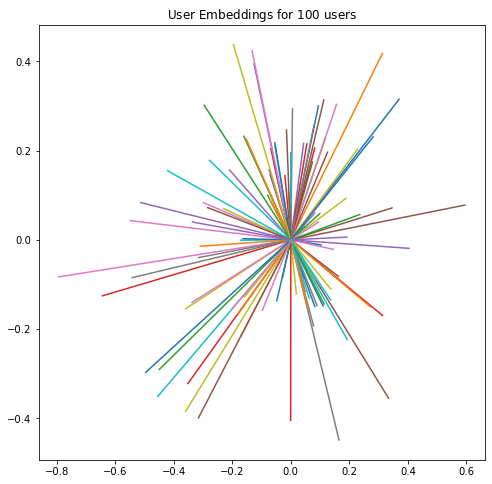

In [367]:
#2D embeddings for some users
#ONLY WORKS IF k=2
domain = np.random.choice(np.arange(uN), 100)
 
plt.figure(figsize=(8, 8))
for i, u in enumerate(U[domain]):
    x = [0, u[0]]
    y = [0, u[1]]
    plt.plot(x, y)
    
plt.title('User Embeddings for $100$ users')
plt.show()

In [358]:
movies[movies['title'].str.contains('Annabelle')]

,movieId,title,genres,gbits
11301,13371.0,Loving Annabelle (2006),"[Drama, Romance]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22399,6202.0,Annabelle (2014),[Horror],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
44100,43026.0,Annabelle Serpentine Dance (1895),[Documentary],"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
47732,5893.0,Annabelle: Creation (2017),[Horror],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
49742,31641.0,Annabelle Hooper and the Ghosts of Nantucket (...,"[Children, Mystery]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
52346,31798.0,Annabelle's Wish (1997),"[Animation, Children]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
60526,5928.0,Annabelle Comes Home (2019),[Horror],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


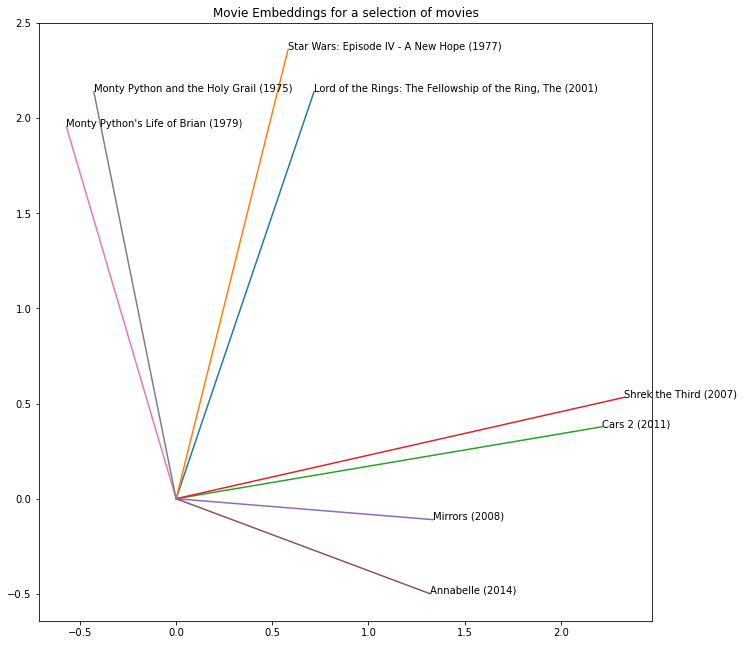

In [368]:
#2D embeddings for some movies
#ONLY WORKS IF k=2
domain = [202, 76, 687, 551, 5859, 6202, 100, 101]

names = ['']*len(domain)
for i, d in enumerate(domain):
    names[i] = movies[movies['movieId'] == d]['title'].values[0]
 
plt.figure(figsize=(11, 11))
for i, v in enumerate(V[domain]):
    x = [0, v[0]]
    y = [0, v[1]]
    plt.plot(x, y)
    plt.annotate(names[i], (v[0], v[1]))
    
plt.title('Movie Embeddings for a selection of movies')
plt.rcParams.update({'font.size': 10})
plt.show()